# ComplexUpset
A library for creating complex UpSet plots based on `ggplot2` and `patchwork`.

## Install

From `R` console run:

```R
if(!require(devtools)) install.packages("devtools")
devtools::install_github("krassowski/complex-upset")
```

### Python integration for use in Jupyter Notebooks (optional)

Please install the requirements using:
    
```bash
pip install -r requirements.txt
```

Load `rpy2` extension:

In [1]:
%%capture
%load_ext rpy2.ipython

## Load ggplot2 and ComplexUpset

In [2]:
%%R
library(ggplot2)
library(ComplexUpset)

## Prepare the datasets

If you wish to use R only, you can use the movies dataset from `ggplot2movies` package. I trust that as an R user you now how to proceed from here.

### Python

In [3]:
from pydataset import data as load_data
movies = load_data('movies').dropna()
movies.head(3).T

,48,112,124
title,'Til There Was You,10 Things I Hate About You,100 Mile Rule
year,1997,1999,2002
length,113,97,98
budget,2.3e+07,1.6e+07,1.1e+06
rating,4.8,6.7,5.6
votes,799,19095,181
r1,4.5,4.5,4.5
r2,4.5,4.5,4.5
r3,4.5,4.5,4.5
r4,14.5,4.5,4.5


In [4]:
genres = list(movies.columns[-7:])
genres

['Action', 'Animation', 'Comedy', 'Drama', 'Documentary', 'Romance', 'Short']

Convert the genre indicator columns to use boolean values:

In [5]:
movies[genres] = movies[genres] == 1
movies[genres].head(3).T

,48,112,124
Action,False,False,False
Animation,False,False,False
Comedy,True,True,True
Drama,False,False,False
Documentary,False,False,False
Romance,True,True,False
Short,False,False,False


### Quick notes on `rpy2` `%%R` magic usage:

- use `-i` switch to import data into R using rpy2 interface
- `-w` and `-h` can be used to adjust the width and height of the plot
- `-r` switch can be used to adjust DPI

## 0. Basic usage

There are two required arguments:
- the first argument is expected to be a dataframe with both group indicator variables and covariates,
- the second argument specifies a list with names of column which indicate the group membership.

Additional arguments can be provided, such as `name` (specifies xlab for intersection matrix) or `width_ratio` (specifies how much space should be occupied by the set size panel). Other such arguments are discussed at length later in this document.

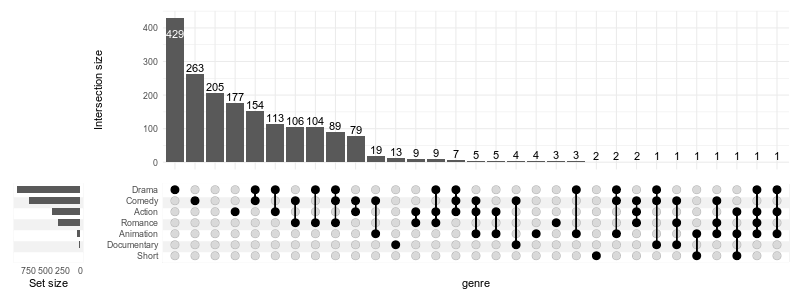

In [6]:
%%R -i movies -i genres -w 800 -h 300
upset(movies, genres, name='genre', width_ratio=0.1)

## 1. Adding components

We will focus on the intersections with at least ten members `(min_size=10)` and on a few variables which are significantly different between the intersections (see 2. Running statistical tests).

We can add multiple annotation components (also called panels):

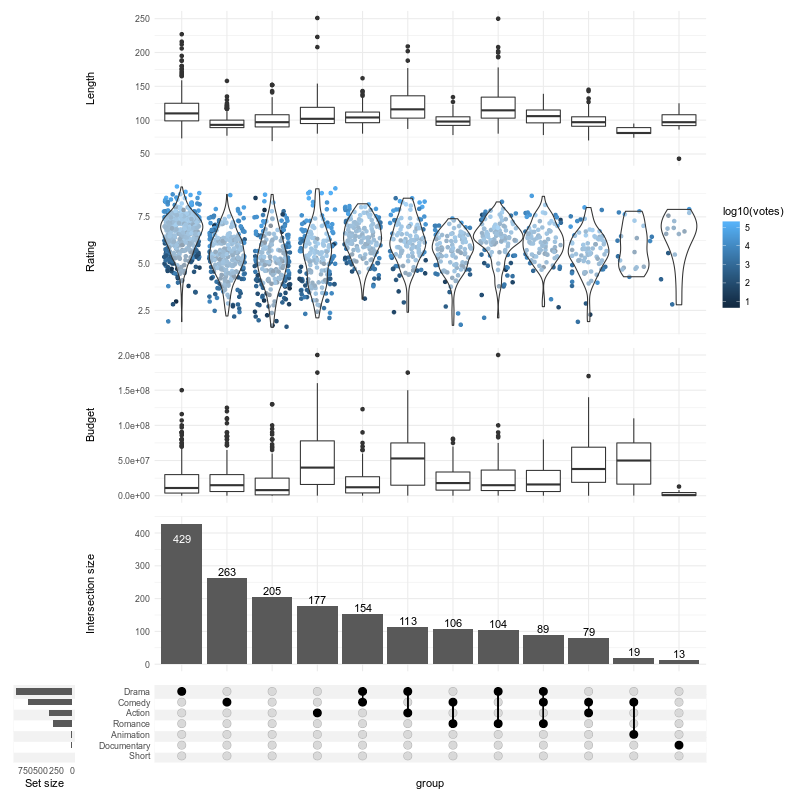

In [7]:
%%R -w 800 -h 800

upset(
    movies,
    genres,
    annotations = list(
        'Length'=list(
            aes=aes(x=intersection, y=length),
            geom=geom_boxplot()
        ),
        'Rating'=list(
            aes=aes(x=intersection, y=rating),
            geom=list(
                # checkout ggbeeswarm::geom_quasirandom for better results!
                geom_jitter(aes(color=log10(votes))),
                geom_violin(width=1.1, alpha=0.5)
            )
        ),
        'Budget'=list(
            aes=aes(x=intersection, y=budget),
            geom=geom_boxplot()
        )
    ),
    min_size=10,
    width_ratio=0.1
)

For simple annotations, such as the length above, you can use a shorthand notation of `upset_annotate`:

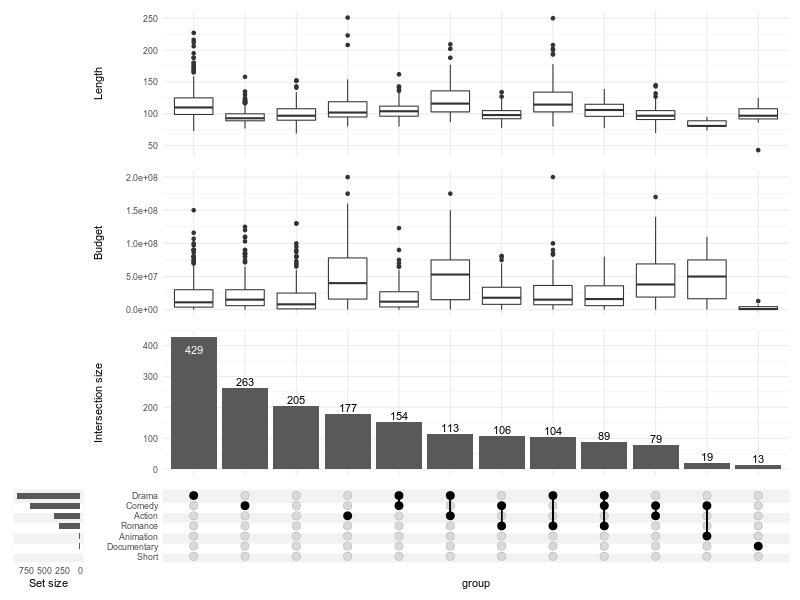

In [8]:
%%R -w 800 -h 600

upset(
    movies,
    genres,
    annotations = list(
        'Length'=upset_annotate('length', geom_boxplot()),
        'Budget'=upset_annotate('budget', geom_boxplot())
    ),
    min_size=10,
    width_ratio=0.1
)

You can also use of barplots to demonstrate difference in proportions of categorical variables:

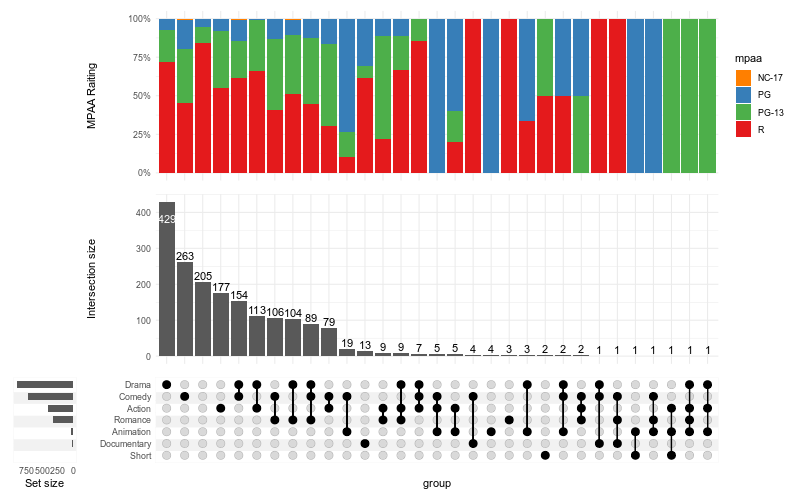

In [9]:
%%R -w 800 -h 500

upset(
    movies,
    genres,
    annotations = list(
        'MPAA Raiting'=list(
            aes=aes(x=intersection, fill=mpaa),
            geom=list(
                geom_bar(stat='count', position='fill'),
                scale_y_continuous(labels=scales::percent_format()),
                scale_fill_manual(values=c(
                    'R'='#E41A1C', 'PG'='#377EB8',
                    'PG-13'='#4DAF4A', 'NC-17'='#FF7F00'
                ))
            )
        )
    ),
    width_ratio=0.1
)

## 2. Running statistical tests

In [10]:
%R upset_test(movies, genres)

[1] "year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, mpaa differ significantly between intersections"


,variable,p.value,statistic,test,fdr
length,length,6.511525e-71,422.884445,Kruskal-Wallis rank sum test,1.106959e-69
rating,rating,1.209027e-46,301.727638,Kruskal-Wallis rank sum test,1.027673e-45
budget,budget,3.899860e-44,288.974760,Kruskal-Wallis rank sum test,2.209921e-43
r8,r8,9.900004e-39,261.288151,Kruskal-Wallis rank sum test,4.207502e-38
mpaa,mpaa,3.732200e-35,242.779393,Kruskal-Wallis rank sum test,1.268948e-34
r9,r9,1.433256e-30,218.781602,Kruskal-Wallis rank sum test,4.060891e-30
r1,r1,2.211600e-23,180.327398,Kruskal-Wallis rank sum test,5.371029e-23
r4,r4,1.008119e-18,154.627715,Kruskal-Wallis rank sum test,2.142254e-18
r3,r3,2.568227e-17,146.702174,Kruskal-Wallis rank sum test,4.851095e-17
r5,r5,9.823827e-16,137.663096,Kruskal-Wallis rank sum test,1.670051e-15


`Kruskal-Wallis rank sum test` is not always the best choice.

You can either change the test for:
 - all the variables (`test=your.test`), or
 - specific variables (using `tests=list(variable=some.test)` argument)

The tests are called with `(formula=variable ~ intersection, data)` signature, such as accepted by `kruskal.test`. The result is expected to be a list with following members:
- `p.value`
- `statistic`
- `method`

It is easy to adapt tests which do not obey this signature/output convention; for example the Chi-squared test and anova can be wrapped with two-line functions as follows:

In [11]:
%%R
chisq_from_formula = function(formula, data) {
    chisq.test(
        ftable(formula, data)
    )
}

anova_single = function(formula, data) {
    result = summary(aov(formula, data))
    list(
        p.value=result[[1]][['Pr(>F)']][[1]],
        method='Analysis of variance Pr(>F)',
        statistic=result[[1]][['F value']][[1]]
    )
}

custom_tests = list(
    mpaa=chisq_from_formula,
    budget=anova_single
)

In [12]:
%R head(upset_test(movies, genres, comparisons=list(tests=custom_tests)))

[1] "year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, mpaa differ significantly between intersections"


,variable,p.value,statistic,test,fdr
length,length,6.511525e-71,422.884445,Kruskal-Wallis rank sum test,1.106959e-69
budget,budget,1.348209e-60,13.663948,Analysis of variance Pr(>F),1.145977e-59
rating,rating,1.209027e-46,301.727638,Kruskal-Wallis rank sum test,6.851151e-46
mpaa,mpaa,9.799097e-42,406.338139,Pearson's Chi-squared test,4.164616e-41
r8,r8,9.900004e-39,261.288151,Kruskal-Wallis rank sum test,3.366002e-38
r9,r9,1.433256e-30,218.781602,Kruskal-Wallis rank sum test,4.060891e-30


Many tests will require at least two observations in each group. You can skip intersections with less than two members with `min_size=2`.

In [13]:
%R tail(upset_test(movies, genres, comparisons=list(test=bartlett.test, min_size=2)))

[1] "NA, year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, NA differ significantly between intersections"


,variable,p.value,statistic,test,fdr
year,year,1.041955e-67,386.536991,Bartlett test of homogeneity of variances,1.302444e-67
length,length,3.982729e-67,383.701476,Bartlett test of homogeneity of variances,4.595457e-67
budget,budget,7.637563e-50,298.899113,Bartlett test of homogeneity of variances,8.183103e-50
rating,rating,3.980194e-06,66.632766,Bartlett test of homogeneity of variances,3.980194e-06
title,title,NaN,NaN,Bartlett test of homogeneity of variances,NaN
mpaa,mpaa,NaN,NaN,Bartlett test of homogeneity of variances,NaN


### Ignore specific variables

You may want to exclude variables which are:
 - highly correlated and therefore interfering with the FDR calculation, or
 - simply irrelevant

In the movies example, the title variable is not a reasonable thing to compare. We can ignore it using:

In [14]:
%%R
# note: title no longer present
rownames(upset_test(movies, genres, comparisons=list(ignore=c('title'))))

[1] "year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, mpaa differ significantly between intersections"
 [1] "length" "rating" "budget" "r8"     "mpaa"   "r9"     "r1"     "r4"    
 [9] "r3"     "r5"     "r7"     "r2"     "r10"    "votes"  "r6"     "year"  


## 3. Adjusting "Intersection size" aesthetics

### 3.1 Counts

The counts over the bars can be disabled:

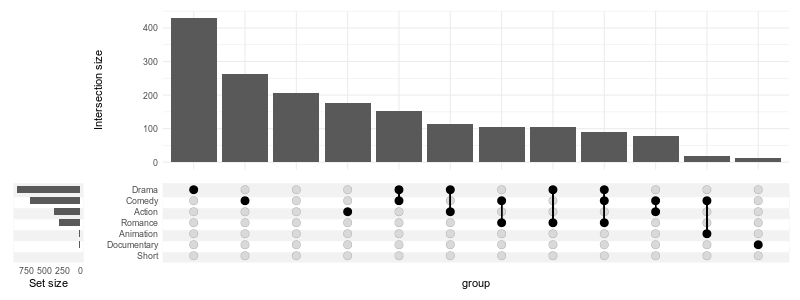

In [15]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(counts=FALSE)
    ),
    min_size=10,
    width_ratio=0.1
)

The colors can be changed:

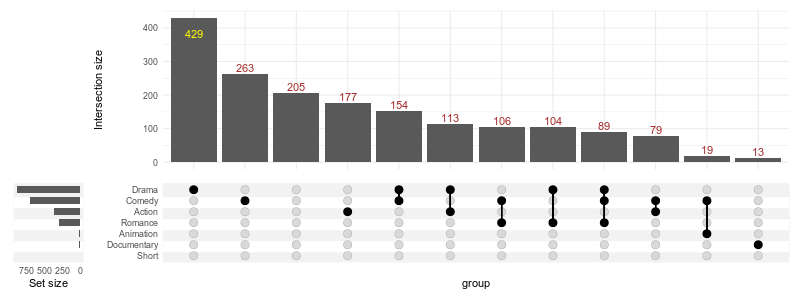

In [16]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            text_colors=c(
                on_background='brown', on_bar='yellow'
            )
        )
    ),
    min_size=10,
    width_ratio=0.1
)

Any parameter supported by `geom_text` can be passed in `text` list:

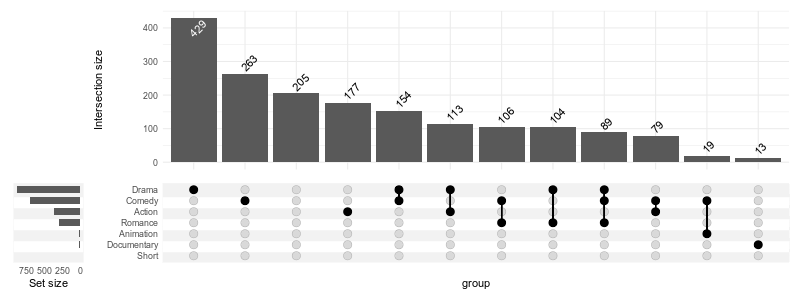

In [17]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            text=list(
                vjust=-0.1,
                hjust=-0.1,
                angle=45
            )
        )
    ),
    min_size=10,
    width_ratio=0.1
)

### 3.2 Fill the bars

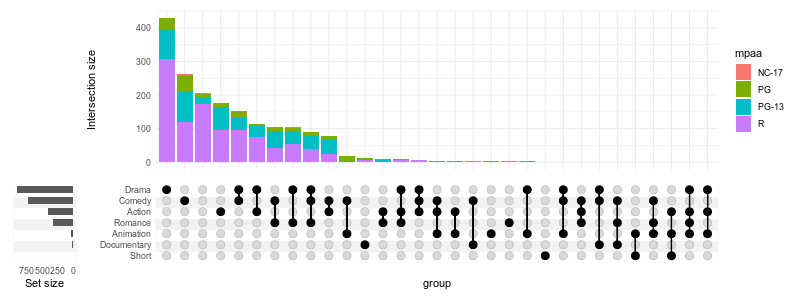

In [18]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=FALSE,
            aes=aes(fill=mpaa)
        )
    ),
    width_ratio=0.1
)

### 3.3 Adjusting the height of the matrix/intersection size

Setting `height_ratio=1` make the intersection matrix and the intersection size have an equal height:

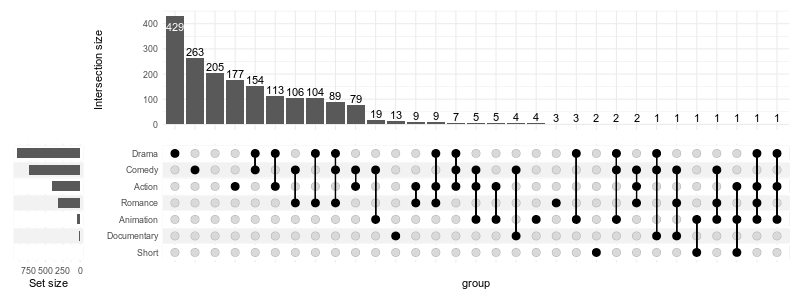

In [19]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    height_ratio=1,
    width_ratio=0.1
)

### 3.5 Hiding intersection size

You can always disable the intersection size altogether:

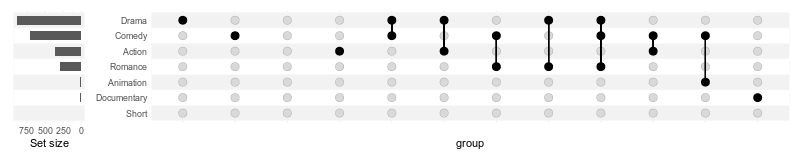

In [20]:
%%R -w 800 -h 160
upset(
    movies,
    genres,
    base_annotations=list(),
    min_size=10,
    width_ratio=0.1
)

## 4. Adjusting other aesthetics

### Stripes

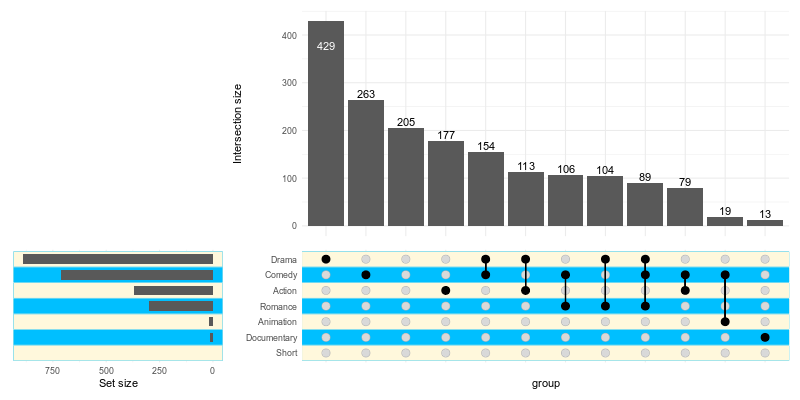

In [21]:
%%R -w 800 -h 400
upset(
    movies,
    genres,
    stripes=c('cornsilk1', 'deepskyblue1'),
    min_size=10
)

To effectively disable the stripes:

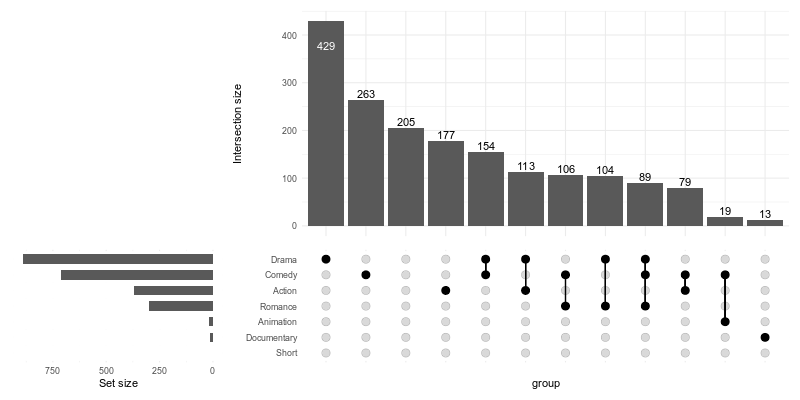

In [22]:
%%R -w 800 -h 400
upset(
    movies,
    genres,
    stripes=c('white', 'white'),
    min_size=10
)

### Adding title

Adding title with `ggtitle` with add it to the intesection matrix:

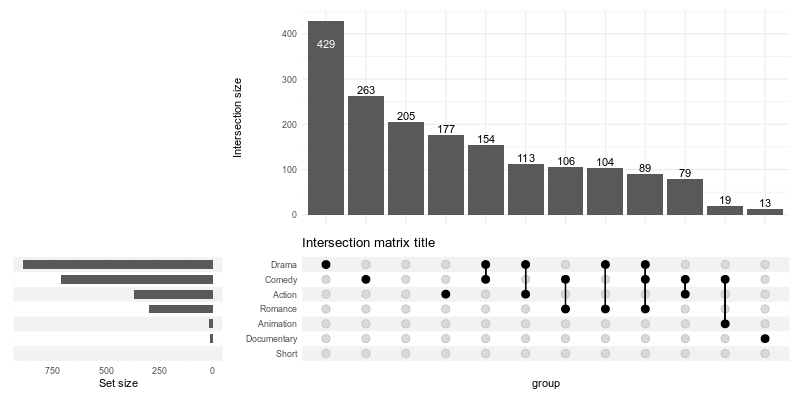

In [23]:
%%R -w 800 -h 400
upset(movies, genres, min_size=10) + ggtitle('Intersection matrix title')

In order to add a title for the entire plot, you need to wrap the plot:

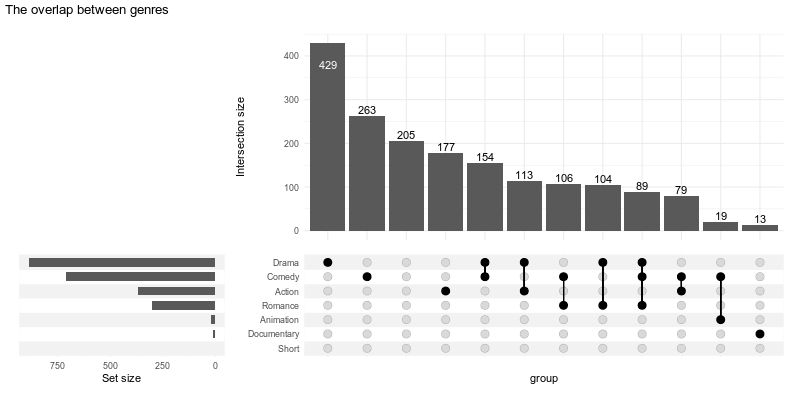

In [24]:
%%R -w 800 -h 400
upset(movies, genres, min_size=10, wrap=TRUE) + ggtitle('The overlap between genres')

## 5. Themes

The themes for specific components are defined in `upset_themes` list, which themes for contains:

In [25]:
%%R
names(upset_themes)

[1] "intersections_matrix" "Intersection size"    "overall_sizes"       
[4] "default"             


You can substitute this list for your own using themes argument. While you can specify a theme for every component, if you omit one or more components those will be taken from the 'default'.

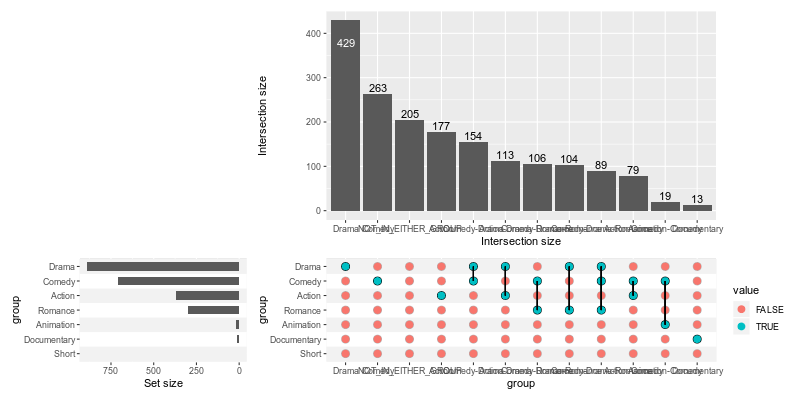

In [26]:
%%R -w 800 -h 400
upset(movies, genres, min_size=10, themes=list(default=theme()))

You can also add themes for your custom panels/annotations here:

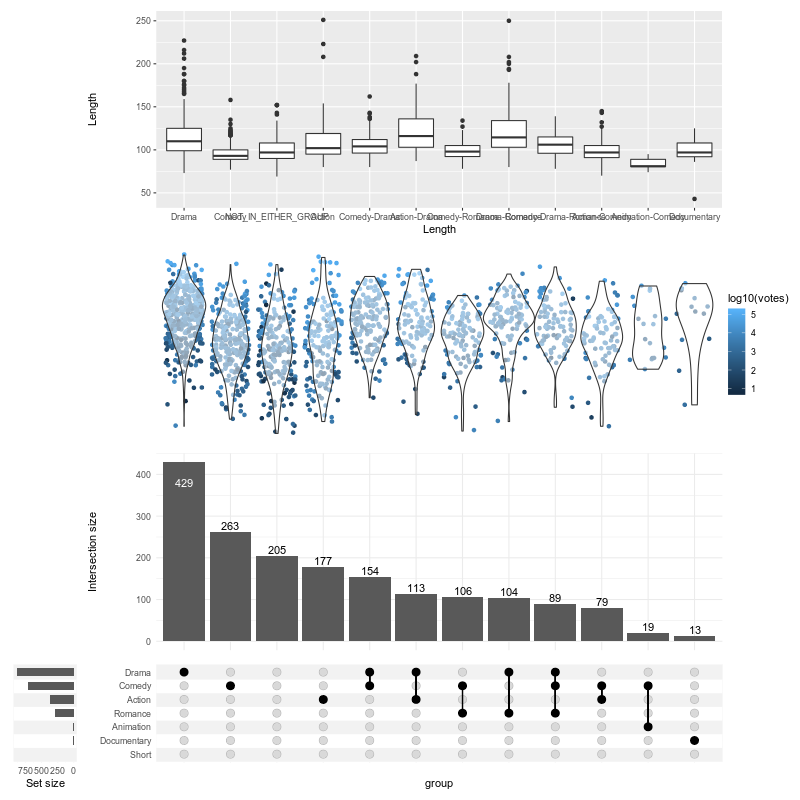

In [27]:
%%R -w 800 -h 800

upset(
    movies,
    genres,
    annotations = list(
        'Length'=list(
            aes=aes(x=intersection, y=length),
            geom=geom_boxplot()
        ),
        'Rating'=list(
            aes=aes(x=intersection, y=rating),
            geom=list(
                geom_jitter(aes(color=log10(votes))),
                geom_violin(width=1.1, alpha=0.5)
            )
        )
    ),
    min_size=10,
    width_ratio=0.1,
    themes=modifyList(
        upset_themes,
        list(Rating=theme_void(), Length=theme())
    )
)